# Tissue Morphing

## Notebook purpose

The purpose of this notebook is to implement and explore tissue morphing across sequential images, creating an intermediate representation of tissue layers. In this notebook, we will take consecutive images of tissue samples and generate smooth transitions between them, effectively constructing intermediate states that represent gradual morphological changes.

## Imports

- MiMorph: Implementation of previous pipeline steps.
- Matplotlib: Visualisation.
- OpenCV(cv2): Tools for morphing and processing images.

In [1]:
from mimorph import tissue_classes
from mimorph import *
import sys
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import cv2

## Data Import

In [2]:
sys.modules['tissue_classes'] = tissue_classes

load_path = Path('../data/')
to_load = ['slide_1.pkl', 'slide_2.pkl']
slides = []

for file_path in load_path.glob('*.pkl'):
    if file_path.name in to_load:
        with open(file_path, 'rb') as f:
            print(f'Loading {file_path}...')
            obj = pickle.load(f)
            slides.append(obj)

Loading ..\data\slide_1.pkl...
Loading ..\data\slide_2.pkl...


## Registration

In this section, consecutive tissue images within each slide are aligned using a registration procedure. For each slide, the code iterates over the tissue images, performing two types of registration. First, a training registration is performed between every other image to establish robust transformations for the morphing process. Second, a validation registration is carried out between consecutive images to provide a real reference for evaluating the morphing results. This valid image serves as a benchmark to check whether the tissue generated by morphing closely resembles the actual transformed tissue.

### Helper Functions

`register` - Wrapper to registration provided from previous notebooks.
`copy_tissue` - Creates new tissue object with given item.

In [3]:
affine_register = TissueAffineRegister('../data/params/optuna_affine_2025-08-23_22-48-43.json')
non_affine_register = TissueNonAffineRegister('../data/params/optuna_non_affine_2025-08-24_02-32-01.json')

def copy_tissue(t):
    return Tissue(t.he, t.rgb, t.mask)

def register(t1, t2):
    t2_reg = affine_register.register(t1, t2)
    t2_reg = non_affine_register.register(t1, t2_reg)

    return t2_reg

Loading parameters from file: ../data/params/optuna_affine_2025-08-23_22-48-43.json ...
Loading parameters from file: ../data/params/optuna_non_affine_2025-08-24_02-32-01.json ...


### Prepare morphing data

The dataset is structured into batches, each comprising a validation sample and corresponding training samples. The validation sample is derived by registering the central slice to the first slice. The training samples consist of two slices: `t1`, representing the slice preceding the validation sample, and `t2`, representing the subsequent slice, which is registered to `t1`.

In [4]:
data = []

for j, slide in enumerate(slides):
    print(f'Slide {j+1}/{len(slides)}:')
    for i in range(0, len(slide)-2):
        reg_batch = {}
        reg_batch['t1'] = copy_tissue(slide[i])
        print(f'   Registering({i+1}/{len(slide)-2}) {i} -> {i+2} (training)')
        reg_batch['t2'] = register(slide[i], slide[i+2])
        print(f'   Registering({i+1}/{len(slide)-2}) {i} -> {i+1} (validation)')
        reg_batch['valid'] = register(slide[i], slide[i+1])
        data.append(reg_batch)

Slide 1/2:
   Registering(1/1) 0 -> 2 (training)
   Registering(1/1) 0 -> 1 (validation)
Slide 2/2:
   Registering(1/2) 0 -> 2 (training)
   Registering(1/2) 0 -> 1 (validation)
   Registering(2/2) 1 -> 3 (training)
   Registering(2/2) 1 -> 2 (validation)


## Morphing


In order to evaluate different strategies for tissue image morphing, two approaches were examined: linear cross-dissolve and optical flow. A comparison of these methods enables an assessment of their ability to preserve morphological structures and ensure smooth transitions across tissue slices.

### Helper functions

In [5]:
def img_float(img):
    img_float = img.astype(np.float32)
    
    if img_float.max() > 1.0:
        img_float /= 255.0
    
    return img_float

def img_uint(img):
    if img.max() <= 1.0:
        img_uint = (img * 255).astype(np.uint8)
    else:
        img_uint = img.astype(np.uint8)
    
    return img_uint

def morph(index, algorithm, morph_rgb: bool = False):
    assert index < len(data)
    
    def morph_img(img1, img2):
        return img_uint(algorithm(img_float(img1), img_float(img2)))
    
    t1, t2 = data[index]['t1'], data[index]['t2']
    he_morph = morph_img(t1.he, t2.he)

    if morph_rgb:
        rgb_morph = morph_img(t1.rgb, t2.rgb)
    else:
        rgb_morph = np.zeros_like(t1.rgb)
    return Tissue(he=he_morph, rgb=rgb_morph, mask=tissue_create_mask(he_morph))

### Metric

To quantitatively evaluate the quality of the morphing results, two metrics were applied: mean squared error (MSE) and Laplacian variance. The MSE, computed within the mask region, measures the intensity differences between the morphed slice and the validation slice, providing an estimate of reconstruction accuracy. The Laplacian variance captures the sharpness of the morphed image by quantifying edge detail, serving as an indicator of structural preservation. In addition, a mask difference measure was used to assess discrepancies in the segmented tissue regions.

In [11]:
def scaled_mse(morph, valid, mask):
    diff = (morph - valid) ** 2
    return diff[mask].mean()

def sharpness_laplacian(morph, valid, mask):
    return cv2.Laplacian(morph.astype(np.float64), cv2.CV_64F)[mask].var()

metrics = {
    'MSE': scaled_mse,
    'Laplacian': sharpness_laplacian
}

def morph_metric(index, result, mask_diff = True):
    assert index < len(data)

    def it(img):
        return np.moveaxis(img, 2, 0)
    def score_img(img1, img2, mask, score_func):
        return score_func(img_float(img1), img_float(img2), mask)
    
    valid = data[index]['valid']
    metric_mask = np.logical_or(result.mask, valid.mask)
    
    scores = {}
    if mask_diff:
        mask_difference = np.logical_xor(result.mask, valid.mask).sum()
        scores['Mask_difference'] = mask_difference

    for name, metric in metrics.items():
        values = []
        
        for result_ch, valid_ch in zip(it(result.he), it(valid.he)):
            values.append(score_img(result_ch, valid_ch, metric_mask, metric))
        
        scores[name] = sum(values)/len(values)

    return scores

### Plot Morph

In [7]:
def plot_channel_diff(index, result, title=''):
    valid = data[index]['valid']
    hem1, hem2 = result.hem, valid.hem
    eos1, eos2 = result.eos, valid.eos

    fig, axes = plt.subplots(2, 2, figsize=(10,10))
    fig.suptitle(title, fontsize=20)
    axes[0,0].set_title('Morphed')
    axes[0,0].imshow(result.eos)
    axes[0,1].set_title('Validation')
    axes[0,1].imshow(valid.rgb)
    axes[1,0].set_title('Hematoxylin')
    axes[1,0].imshow(cv2.absdiff(hem1, hem2), cmap='magma')
    axes[1,1].set_title('Eosine')
    axes[1,1].imshow(cv2.absdiff(eos1, eos2), cmap='magma')
    for ax in axes.flatten():
        ax.axis('off')
    plt.show()

### Linear Cross-Dissolve

The linear cross-dissolve method produces intermediate slices by linearly interpolating pixel intensities between adjacent tissue images. Given the very large image sizes, even small pixel-level errors accumulate substantially, which is reflected in the high mask difference (4,198,267). The mean squared error (0.0032) indicates moderate intensity mismatch, while the low Laplacian variance (0.0028) suggests limited sharpness preservation.

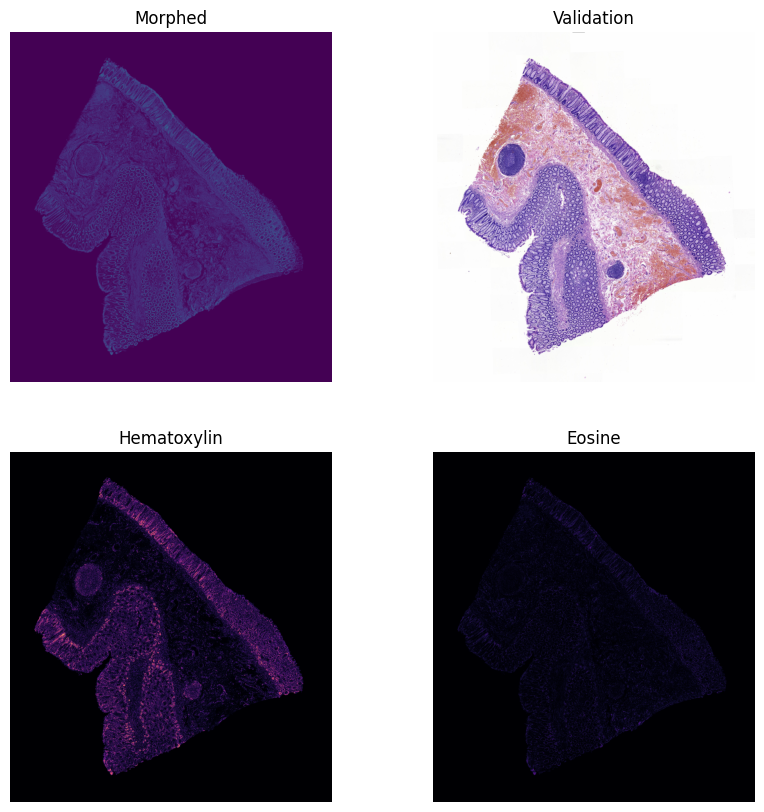

{'Mask_difference': np.int64(4198267), 'MSE': np.float32(0.0032209216), 'Laplacian': np.float64(0.0027731825878896106)}


In [8]:
def linear_morph(img1, img2):
    alpha = 0.5
    blended = (1 - alpha) * img1 + alpha * img2
    return np.clip(blended, 0, 1)

index = 0
result = morph(index, linear_morph, True)
plot_channel_diff(index, result)

linear_metrics = morph_metric(index, result)
print(linear_metrics)

### Optical flow

The optical flow method estimates pixel-wise displacement fields to align neighboring slices, aiming for smoother structural transitions. Despite its sophistication, the evaluation on large-scale tissue images yielded results comparable to linear cross-dissolve: a high mask difference (4,198,267), an MSE of 0.0032, and a low Laplacian variance (0.0028), indicating only limited improvement in accuracy and sharpness.

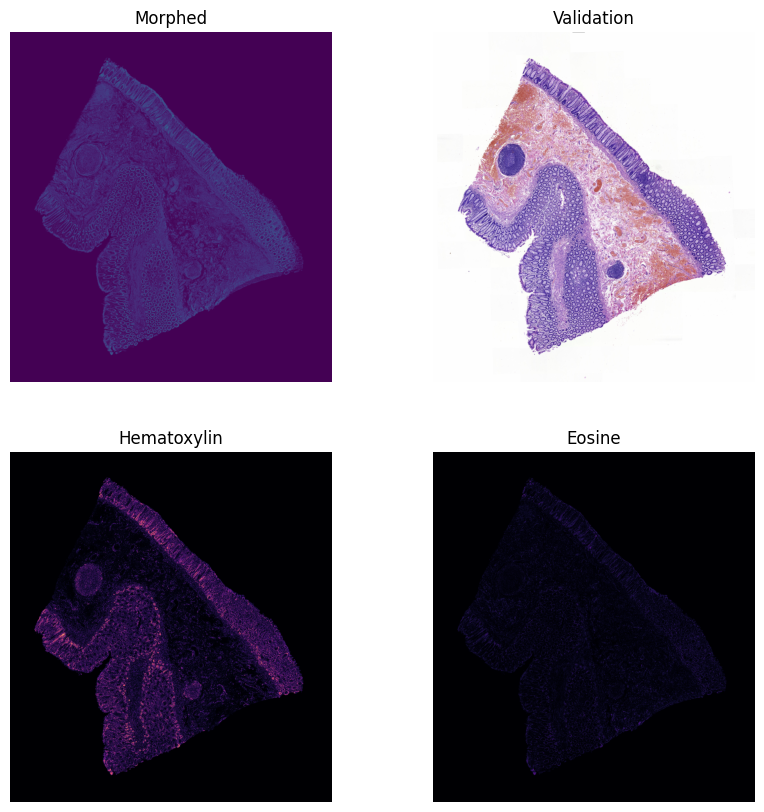

{'Mask_difference': np.int64(4198267), 'MSE': np.float32(0.0032209216), 'Laplacian': np.float64(0.0027731825878896106)}


In [13]:
def optical_flow_morph(t1, t2):
    alpha=0.5

    if t1.ndim == 2:
        t1 = t1[..., np.newaxis]
        t2 = t2[..., np.newaxis]

    flows = []
    for c in range(t1.shape[-1]):
        img1_gray = t1[..., c]
        img2_gray = t2[..., c]

        flow = cv2.calcOpticalFlowFarneback(
            img1_gray.astype(np.float32),
            img2_gray.astype(np.float32),
            None,
            pyr_scale=0.5, levels=3, winsize=15,
            iterations=3, poly_n=5, poly_sigma=1.2, flags=0
        )
        flows.append(flow)

    avg_flow = np.mean(flows, axis=0)

    h, w = t1.shape[:2]
    map_x, map_y = np.meshgrid(np.arange(w), np.arange(h))
    map_x = (map_x + alpha * avg_flow[...,0]).astype(np.float32)
    map_y = (map_y + alpha * avg_flow[...,1]).astype(np.float32)

    warped = np.zeros_like(t1, dtype=np.float32)
    for c in range(t1.shape[-1]):
        warped[...,c] = cv2.remap(t1[...,c], map_x, map_y, interpolation=cv2.INTER_LINEAR)

    blended = (1 - alpha) * warped + alpha * t2
    return blended

index = 0
result = morph(index, optical_flow_morph)
plot_channel_diff(index, result)

of_metrics = morph_metric(index, result)
print(of_metrics)

### Conclusions

Due to limited time and data, this project compared only two morphing techniques, which produced similar results. The main reason for the limited effectiveness of morphing is likely the suboptimal non-affine alignment, originally tuned for consecutive tissue slices rather than every second slice. Future work should therefore focus on optimizing alignment parameters specifically for this setting and evaluating the improvements against the current approach. Additionally, access to a larger dataset would enable the exploration of more advanced, AI-based methods, which could significantly enhance both the morphing and alignment pipeline.